In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load CNN and UNET
from CNN_Mask_to_Tens import CNN
# from UNet import UNet
# Define the U-Net architecture for binary segmentation
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder (downsampling path)
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.enc_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc_conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc_conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck_conv1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bottleneck_conv2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Decoder (upsampling path)
        self.dec_upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv1 = nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.dec_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv3 = nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1)
        self.dec_conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.dec_upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv5 = nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1)
        self.dec_conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.dec_upsample4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.dec_conv7 = nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1)
        self.dec_conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

          # Output
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1)  # 1x1 convolution for binary segmentation


    def forward(self, x):
        # Encoder (downsampling path)
        enc1 = nn.ReLU()(self.enc_conv1(x))
        enc2 = nn.ReLU()(self.enc_conv2(enc1))
        enc2_pool = self.enc_pool1(enc2)

        enc3 = nn.ReLU()(self.enc_conv3(enc2_pool))
        enc4 = nn.ReLU()(self.enc_conv4(enc3))
        enc4_pool = self.enc_pool2(enc4)

        enc5 = nn.ReLU()(self.enc_conv5(enc4_pool))
        enc6 = nn.ReLU()(self.enc_conv6(enc5))
        enc6_pool = self.enc_pool3(enc6)

        enc7 = nn.ReLU()(self.enc_conv7(enc6_pool))
        enc8 = nn.ReLU()(self.enc_conv8(enc7))
        enc8_pool = self.enc_pool4(enc8)

        # Bottleneck
        bottleneck = nn.ReLU()(self.bottleneck_conv1(enc8_pool))
        bottleneck = nn.ReLU()(self.bottleneck_conv2(bottleneck))

        # Decoder (upsampling path)
        dec1 = self.dec_upsample1(bottleneck)
        dec1 = torch.cat([dec1, enc8], dim=1)
        dec1 = nn.ReLU()(self.dec_conv1(dec1))
        dec1 = nn.ReLU()(self.dec_conv2(dec1))

        dec2 = self.dec_upsample2(dec1)
        dec2 = torch.cat([dec2, enc6], dim=1)
        dec2 = nn.ReLU()(self.dec_conv3(dec2))
        dec2 = nn.ReLU()(self.dec_conv4(dec2))

        dec3 = self.dec_upsample3(dec2)
        dec3 = torch.cat([dec3, enc4], dim=1)
        dec3 = nn.ReLU()(self.dec_conv5(dec3))
        dec3 = nn.ReLU()(self.dec_conv6(dec3))

        dec4 = self.dec_upsample4(dec3)
        dec4 = torch.cat([dec4, enc2], dim=1)
        dec4 = nn.ReLU()(self.dec_conv7(dec4))
        dec4 = nn.ReLU()(self.dec_conv8(dec4))

        # Output
        output = self.output_conv(dec4)
        return output   
    
    # Create an instance of the FCN model
model = UNet()

In [16]:
# Load and preprocess the input image
image = Image.open('Data/R3080_realval/drop_s30_v5_r0.5_str4_pos0_cam0.png')  # Replace 'input_image.jpg' with the path to your input image file

# Create transform
transform = transforms.Compose([
    # transforms.Resize((256, 256)),  # Resize the image to a specific size
    transforms.ToTensor(),    
    transforms.Normalize(mean=[0.4414, 0.4456, 0.3421],  # Normalization of real images
                            std=[0.2741, 0.2734, 0.3030])
])

image = image.convert('RGB')
image = transform(image)



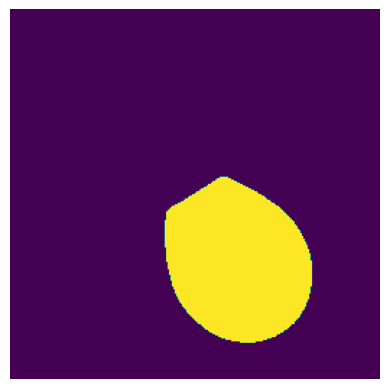

In [12]:
from skimage.filters import threshold_otsu
# UNET PART
model = UNet()

# Load the trained weights
model.load_state_dict(torch.load('Unet_R3080.pt')) # Change trained_model to use desired weights


# Set the model to evaluation mode
model.eval()
# Make a prediction
with torch.no_grad():
    output = model(image.unsqueeze(0))  # Assuming you have the test image as a tensor

# Convert the output tensor to a numpy array and squeeze the batch and channel dimensions
output_1 = output.squeeze(0).squeeze(0).cpu().detach()
output_np = output_1.numpy()

threshold = 0.5  # Adjust the threshold value as needed
# Apply a threshold to convert the output to a binary mask
threshold_value = threshold_otsu(output_np)
mask = (output_np >= threshold).astype(np.uint8)

# Assuming tensor_image is your tensor representation of the image
# Convert the tensor to a PIL Image
pil_image = transforms.ToPILImage()(mask)

pil_image.save("output_UNET.jpg")

# Convert the PIL Image to a NumPy array
numpy_image = np.array(pil_image)

# Display the image using matplotlib
plt.imshow(numpy_image)
plt.axis('off')  # Optional: Turn off axis labels and ticks
plt.show()

In [15]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.4753, 0.4753, 0.4753])
])

# Load model
model = CNN()

# Load the trained weights
model.load_state_dict(torch.load('trained_model_Train_510.pt',map_location=torch.device('cpu'))) # Change trained_model to use desired weights
# Set the model in evaluation mode

model.eval()

input_image = pil_image.convert('RGB')
input_tensor = transform(input_image)

# Make a prediction
with torch.no_grad():
    output_CNN = model(input_tensor)

# Convert the output to a readable format
predicted_value = output_CNN.item()

# Print the predicted value
print('Predicted value:', predicted_value)

Predicted value: 28.731781005859375
